In [1]:
# imported all required libraries 
import pandas as pd
from finta import TA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read into csv file , removed unwanted columns and sorted into ascending order. 
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,
2010-07-24,0.0545,0.0545,0.0545,0.0545,0.000000e+00,0.000000e+00
2010-07-25,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
2010-07-26,0.0560,0.0560,0.0560,0.0560,0.000000e+00,0.000000e+00
2010-07-27,0.0600,0.0600,0.0600,0.0600,0.000000e+00,0.000000e+00
2010-07-28,0.0589,0.0589,0.0589,0.0589,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2023-08-18,26659.8500,26784.2300,25721.5300,26058.2600,7.032831e+10,5.115170e+11
2023-08-19,26069.2300,26253.2600,25814.2500,26090.6300,4.769626e+10,5.060530e+11
2023-08-20,26085.1800,26267.3300,26002.0300,26180.0000,3.624048e+10,5.084380e+11


In [3]:
# Get technical indicator
def get_ta(df):
    
    # Calculate ADX
    df['ADX'] = TA.ADX(df)
    
    # Calculate RSI
    df['RSI'] = TA.RSI(df)
    
    # Calculate Bollinger Bands
    bollinger_bands = TA.BBANDS(df)
    df['BollingerUpper'] = bollinger_bands['BB_UPPER']
    df['BollingerMiddle'] = bollinger_bands['BB_MIDDLE']
    df['BollingerLower'] = bollinger_bands['BB_LOWER']
    
    # Calculate EMA21
    df['EMA21'] = TA.EMA(df, 21)
    
    # Calculate SMA99
    df['EMA99'] = TA.EMA(df, 99)
    
    # Calculate EMA151
    df['EMA151'] = TA.EMA(df, 151)
    
    df.dropna(inplace=True)
    
    return df

In [4]:
# defined a function to label trendy and sideways market
# 1 signifies trendy market and 0 signifies sideways market 
def label_market(df, criteria):
    df['MarketLabel'] = 0
    indices = df.index.tolist()
    
    for i in range(len(indices)):
        current_index = indices[i]
        trendy_count = 0
        
        if df.loc[current_index, 'ADX'] > 25:
            trendy_count += 1
        
        if df.loc[current_index, 'RSI'] < 30 or df.loc[current_index, 'RSI'] > 70:
            trendy_count += 1

        if i > 0:
            previous_index = indices[i-1]
            current_width = df.loc[current_index, 'BollingerUpper'] - df.loc[current_index, 'BollingerLower']
            previous_width = df.loc[previous_index, 'BollingerUpper'] - df.loc[previous_index, 'BollingerLower']
            
            if current_width > previous_width:
                trendy_count += 1

        if trendy_count >= criteria:
            df.loc[current_index, 'MarketLabel'] = 1  # Trendy
            
    return df

In [5]:
# defined a function to color trendy and sideways market on a map based on labels 

def plot_colored_market_trends(df):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for date, row in df.iterrows():
        current_price = row['Close']
        current_label = row['MarketLabel']
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [ ]:
df = get_ta(df)
df = label_market(df,2)


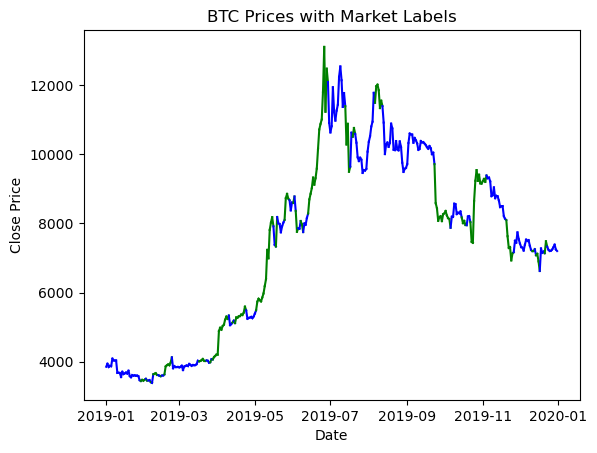

In [7]:
# Market label plot indicating tending and sideways market. As per label assigned by the TIs 
labeled_df = df['2019-01-01':'2019-12-31']
plot_colored_market_trends(labeled_df)

In [8]:
# number of 0's and 1's in the df
df['MarketLabel'].value_counts()

0    2922
1    1837
Name: MarketLabel, dtype: int64

In [9]:
# Splitting the data into train, test and validation sets. 
X = df.drop(columns=["MarketLabel"]).loc[:'2023-03-31']
y = df["MarketLabel"].loc[:'2023-03-31']
validation_date = pd.Timestamp('2023-04-01')
X_validation = df.drop(columns=["MarketLabel"]).loc[validation_date:]
y_validation = df["MarketLabel"].loc[validation_date:]






In [10]:
# Split the data using train_test_split
# Assigned a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [11]:
# Created a StandardScaler instance.
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model 

In [12]:
# Initiated SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Used the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Reviewed the model's predicted values
print(svm_pred)

[0 0 1 ... 1 0 0]


In [13]:
# Accuracy score 
accuracy_score(y_test, svm_pred)

0.8310225303292894

In [14]:
# Generated a confusion matrix for the model

confusion_matrix(y_test, svm_pred)

array([[684,  26],
       [169, 275]], dtype=int64)

In [15]:
# Generated a classification report for the model
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       710
           1       0.91      0.62      0.74       444

    accuracy                           0.83      1154
   macro avg       0.86      0.79      0.81      1154
weighted avg       0.84      0.83      0.82      1154



# GB Model 

In [16]:
# Initialized Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_clf.fit(X_train_scaled, y_train)

# Predicted the labels
y_pred = gb_clf.predict(X_test_scaled)

# Generated a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       710
           1       0.94      0.75      0.83       444

    accuracy                           0.88      1154
   macro avg       0.90      0.86      0.87      1154
weighted avg       0.89      0.88      0.88      1154



## Logistics Regression

In [17]:
# Initialized logistics Regression Classifier

lg_model = LogisticRegression(random_state=1)  

# Fit the model using training data
lg_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [18]:
# Predicted the labels
lg_predictions = lg_model.predict(X_test_scaled)

In [19]:
# Accuracy score 
accuracy_score(y_test, lg_predictions)

0.6863084922010398

In [20]:
# Generated a confusion matrix for the model
confusion_matrix(y_test, lg_predictions)

array([[588, 122],
       [240, 204]], dtype=int64)

In [21]:
# Generated a classification report for the model

print(classification_report(y_test, lg_predictions))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       710
           1       0.63      0.46      0.53       444

    accuracy                           0.69      1154
   macro avg       0.67      0.64      0.65      1154
weighted avg       0.68      0.69      0.67      1154



## Random Forest 

In [22]:
# Initialized random forest Classifier

rf_model = RandomForestClassifier(random_state=1)

# Fit the model using training data
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1)

In [23]:
# Predicted the labels

rf_predictions = rf_model.predict(X_test_scaled)

In [24]:
# Accuracy score 

accuracy_score(y_test, rf_predictions)

0.9116117850953206

In [25]:
# Generated a confusion matrix for the model

confusion_matrix(y_test, rf_predictions)

array([[666,  44],
       [ 58, 386]], dtype=int64)

In [26]:
# Generated a classification report for the model

print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       710
           1       0.90      0.87      0.88       444

    accuracy                           0.91      1154
   macro avg       0.91      0.90      0.91      1154
weighted avg       0.91      0.91      0.91      1154



## LSTM

In [27]:
# Initialized LSTM Classifier

lstm = Sequential()

# Creating the first hidden layer
lstm.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train_scaled.shape[1],1)))
lstm.add(Dropout(0.2))

# Creating the second hidden layer
lstm.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the third hidden layer
lstm.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the fourth hidden layer
lstm.add(LSTM(units = 60, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the output layer to the model 
lstm.add(Dense(units = 1, activation= 'sigmoid'))


In [28]:
# # Display the LSTM model summary
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 14, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 60)            31440     
                                                                 
 dropout_1 (Dropout)         (None, 14, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 14, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [29]:
# # Compile the model
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [30]:
# # Fit the model with the scaled train data and corresponding lables with 50 epochs
lstm.fit(X_train_scaled, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
109/109 [==============================] - 22s 67ms/step - loss: 0.2324 - accuracy: 0.6094
Epoch 2/50
109/109 [==============================] - 7s 65ms/step - loss: 0.2237 - accuracy: 0.6351
Epoch 3/50
109/109 [==============================] - 7s 65ms/step - loss: 0.2056 - accuracy: 0.6995
Epoch 4/50
109/109 [==============================] - 7s 66ms/step - loss: 0.1997 - accuracy: 0.7021
Epoch 5/50
109/109 [==============================] - 7s 66ms/step - loss: 0.1989 - accuracy: 0.7044
Epoch 6/50
109/109 [==============================] - 7s 68ms/step - loss: 0.1960 - accuracy: 0.7085
Epoch 7/50
109/109 [==============================] - 7s 68ms/step - loss: 0.1971 - accuracy: 0.7064
Epoch 8/50
109/109 [==============================] - 7s 67ms/step - loss: 0.1936 - accuracy: 0.7114
Epoch 9/50
109/109 [==============================] - 7s 65ms/step - loss: 0.1913 - accuracy: 0.7183
Epoch 10/50
109/109 [==============================] - 7s 66ms/step - loss: 0.1898 - accur

In [31]:
# # Display the prdictions by the model on the test data
pred = lstm.predict(X_test_scaled)

# # convert predictions to binary and required data structure
lstm_pred= np.where(pred > 0.5, 1, 0).ravel()
lstm_pred

37/37 [==============================] - 3s 21ms/step


array([0, 0, 1, ..., 1, 0, 0])

In [32]:
# # Obtain the classification report of the predictions
print(classification_report(y_test, lstm_pred))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       710
           1       0.90      0.62      0.74       444

    accuracy                           0.83      1154
   macro avg       0.85      0.79      0.81      1154
weighted avg       0.84      0.83      0.82      1154



## Neural Networks 



In [33]:
# # Build the neural network model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
87/87 [==============================] - 2s 12ms/step - loss: 0.6074 - accuracy: 0.6720 - val_loss: 0.5173 - val_accuracy: 0.7417
Epoch 2/50
87/87 [==============================] - 1s 6ms/step - loss: 0.5121 - accuracy: 0.7330 - val_loss: 0.4517 - val_accuracy: 0.7864
Epoch 3/50
87/87 [==============================] - 0s 5ms/step - loss: 0.4619 - accuracy: 0.7626 - val_loss: 0.4093 - val_accuracy: 0.8066
Epoch 4/50
87/87 [==============================] - 0s 5ms/step - loss: 0.4265 - accuracy: 0.7876 - val_loss: 0.3811 - val_accuracy: 0.8268
Epoch 5/50
87/87 [==============================] - 0s 6ms/step - loss: 0.4128 - accuracy: 0.7868 - val_loss: 0.3678 - val_accuracy: 0.8341
Epoch 6/50
87/87 [==============================] - 1s 6ms/step - loss: 0.4035 - accuracy: 0.7977 - val_loss: 0.3584 - val_accuracy: 0.8355
Epoch 7/50
87/87 [==============================] - 0s 6ms/step - loss: 0.3905 - accuracy: 0.8111 - val_loss: 0.3642 - val_accuracy: 0.8283
Epoch 8/50
87/87 [=

## Backtesting Strategy

In [34]:
# defined a new funtion for backtesting 
def plot_colored_market_trends_1(df,predictions):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for i, (date, row) in enumerate(df.iterrows()):
        current_price = row['Close']
        current_label = predictions[i]
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

#### Validation for SVM Model 

In [35]:

#  Scaled the validation data

X_validation_scaled = X_scaler.transform(X_validation)

#  Made predictions on the validation data
svm_validation_pred = svm_model.predict(X_validation_scaled)

#  Evaluated the model's performance
print("Accuracy on validation data: ", accuracy_score(y_validation, svm_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, svm_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, svm_validation_pred))


Accuracy on validation data:  0.8125
Confusion Matrix on validation data: 
 [[98  1]
 [26 19]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88        99
           1       0.95      0.42      0.58        45

    accuracy                           0.81       144
   macro avg       0.87      0.71      0.73       144
weighted avg       0.84      0.81      0.79       144



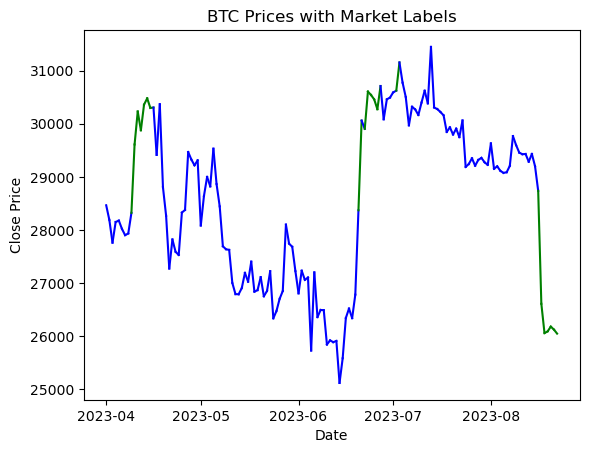

In [36]:
#validation plot for svm
plot_colored_market_trends_1(df[validation_date:],svm_validation_pred)

#### Validation for GB Model 

In [37]:
#  Made predictions on the validation data

gb_validation_pred = gb_clf.predict(X_validation_scaled)

#  Evaluated the model's performance

print("Accuracy on validation data: ", accuracy_score(y_validation, gb_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, gb_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, gb_validation_pred))


Accuracy on validation data:  0.8055555555555556
Confusion Matrix on validation data: 
 [[94  5]
 [23 22]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        99
           1       0.81      0.49      0.61        45

    accuracy                           0.81       144
   macro avg       0.81      0.72      0.74       144
weighted avg       0.81      0.81      0.79       144



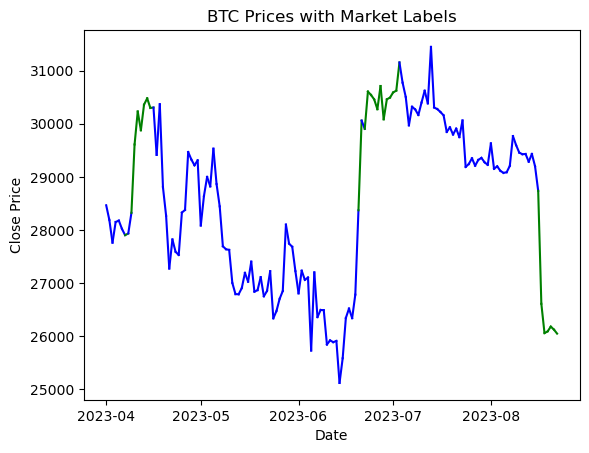

In [38]:
#validation plot for gb model
plot_colored_market_trends_1(df[validation_date:],gb_validation_pred)

#### Validation for Logistics Regression 

In [39]:
#  Made predictions on the validation data

lg_validation_pred = lg_model.predict(X_validation_scaled)

#  Evaluated the model's performance

print("Accuracy on validation data: ", accuracy_score(y_validation, lg_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, lg_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, lg_validation_pred))

Accuracy on validation data:  0.7013888888888888
Confusion Matrix on validation data: 
 [[99  0]
 [43  2]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.82        99
           1       1.00      0.04      0.09        45

    accuracy                           0.70       144
   macro avg       0.85      0.52      0.45       144
weighted avg       0.79      0.70      0.59       144



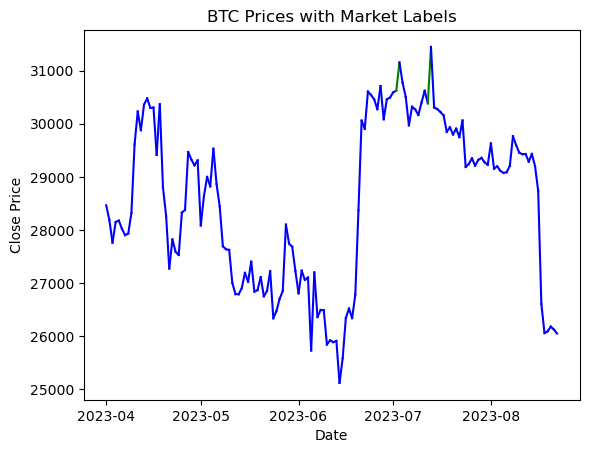

In [73]:
#validation plot for lg model
plot_colored_market_trends_1(df[validation_date:],lg_validation_pred)

#### Validation for Random Forest 

In [41]:
#  Made predictions on the validation data

rf_validation_pred = rf_model.predict(X_validation_scaled)

#  Evaluated the model's performance

print("Accuracy on validation data: ", accuracy_score(y_validation, rf_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, rf_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, rf_validation_pred))

Accuracy on validation data:  0.7916666666666666
Confusion Matrix on validation data: 
 [[98  1]
 [29 16]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.77      0.99      0.87        99
           1       0.94      0.36      0.52        45

    accuracy                           0.79       144
   macro avg       0.86      0.67      0.69       144
weighted avg       0.82      0.79      0.76       144



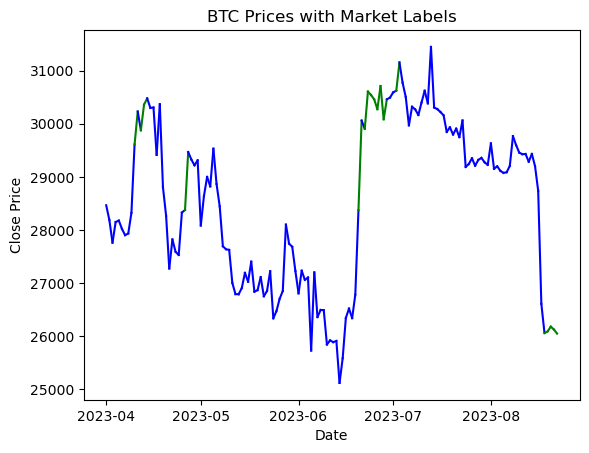

In [42]:
#validation plot for rf model
plot_colored_market_trends_1(df[validation_date:],rf_validation_pred)

#### Validation of LSTM

In [67]:
#  Made predictions on the validation data

lstm_validation_pred = lstm.predict(X_validation_scaled)
#display(lstm_validation_pred[0:101])
#lstm_validation_pred[-5:-1]
lstm_validation_pred =  np.where(lstm_validation_pred > 0.35, 1, 0).ravel()

#  Evaluated the model's performance

print("Accuracy on validation data: ", accuracy_score(y_validation, lstm_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, lstm_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, lstm_validation_pred))

5/5 [==============================] - 0s 22ms/step
Accuracy on validation data:  0.7777777777777778
Confusion Matrix on validation data: 
 [[83 16]
 [16 29]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        99
           1       0.64      0.64      0.64        45

    accuracy                           0.78       144
   macro avg       0.74      0.74      0.74       144
weighted avg       0.78      0.78      0.78       144



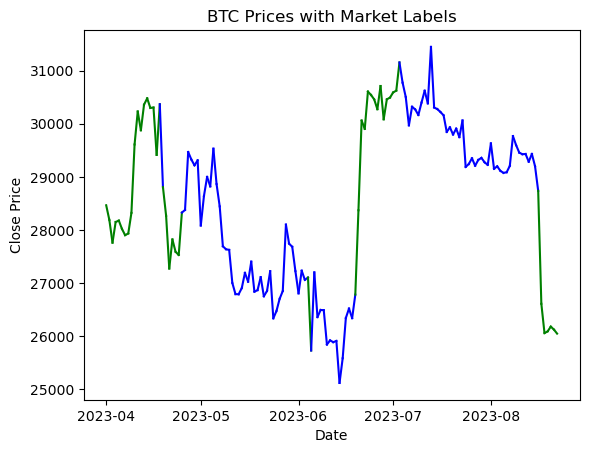

In [68]:
#validation plot for lstm model
plot_colored_market_trends_1(df[validation_date:],lstm_validation_pred)

#### Validation of Neural Network

In [71]:
#  Made predictions on the validation data

nn_validation_pred = nn_model.predict(X_validation_scaled)
nn_validation_pred =  np.where(nn_validation_pred > 0.30, 1, 0).ravel()

#  Evaluated the model's performance

print("Accuracy on validation data: ", accuracy_score(y_validation, nn_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, nn_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, nn_validation_pred))

5/5 [==============================] - 0s 5ms/step
Accuracy on validation data:  0.8333333333333334
Confusion Matrix on validation data: 
 [[82 17]
 [ 7 38]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        99
           1       0.69      0.84      0.76        45

    accuracy                           0.83       144
   macro avg       0.81      0.84      0.82       144
weighted avg       0.85      0.83      0.84       144



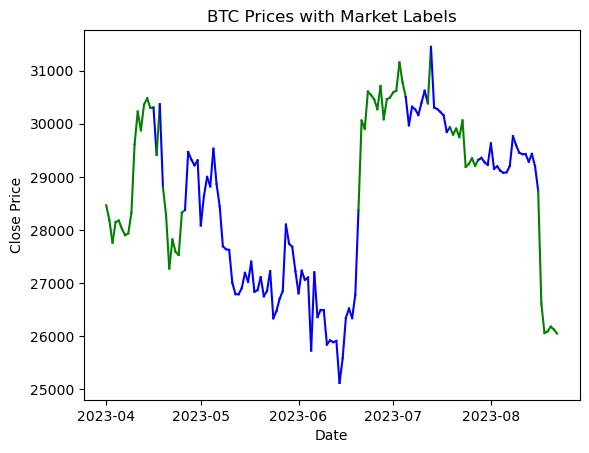

In [72]:
#validation plot for Neural Network model
plot_colored_market_trends_1(df[validation_date:],nn_validation_pred)